In [1]:
!pip install earthpy seaborn geopandas flask-restful flask-ngrok

In [2]:
!pip install gdal

In [3]:
import flask
from flask_ngrok import run_with_ngrok
from flask import Flask
from flask_restful import Resource, Api
import json

In [4]:
from glob import glob
import os
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import patches as mpatches
from matplotlib.colors import ListedColormap
from matplotlib import colors
import matplotlib as mpl
import seaborn as sns

import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.plot import show
from rasterio.plot import reshape_as_raster, reshape_as_image

import gdal 

import geopandas as gpd
from shapely.geometry import mapping, box

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

In [5]:
import io
from matplotlib.colors import colorConverter
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

In [6]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [7]:
%cd '/gdrive/My Drive/NASA SPACE APP'  

/gdrive/.shortcut-targets-by-id/1-DzXj6vS4v93jHi8NfFMhO2Krq3cCtZ2/NASA SPACE APP


In [8]:
class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

In [9]:
def plot_after_flood(ndwi,ndwi_af,resulted_mask):
    # create dummy data
    zvals = ndwi_af.reshape(ndwi.shape[1:])
    zvals2 = resulted_mask.reshape(resulted_mask.shape[1:])

    # generate the colors for your colormap
    color1 = colorConverter.to_rgba('white')
    color2 = colorConverter.to_rgba('black')

    # make the colormaps
    cmap1 = mpl.colors.LinearSegmentedColormap.from_list('my_cmap',['green','blue'],256)
    cmap2 = mpl.colors.LinearSegmentedColormap.from_list('my_cmap2',[color1,color2],256)

    cmap2._init() # create the _lut array, with rgba values

    # create your alpha array and fill the colormap with them.
    # here it is progressive, but you can create whathever you want
    alphas = np.linspace(0, 0.8, cmap2.N+3)
    cmap2._lut[:,-1] = alphas

    fig = plt.figure(figsize=(12, 12)) 
    plt.imshow(zvals, interpolation='nearest', cmap= cmap1, )
    plt.imshow(zvals2, interpolation='nearest', cmap=cmap2, label='flood')
    # plt.colorbar()
    plt.axis('off')

  
    #plt.show()
    #path = 'static/img/floodresult/after_flood_plot_' + location + '.png'
    post_bytes_image = io.BytesIO()
    plt.savefig(post_bytes_image, format='png')
    post_bytes_image.seek(0)
    return post_bytes_image


def plot_before_flood(ndwi,ndwi_af,resulted_mask):

    # create dummy data
    zvals = ndwi.reshape(ndwi_af.shape[1:])
    zvals2 = np.zeros(resulted_mask.shape[1:])

    # generate the colors for your colormap
    color1 = colorConverter.to_rgba('white')
    color2 = colorConverter.to_rgba('black')

    # make the colormaps
    cmap1 = mpl.colors.LinearSegmentedColormap.from_list('my_cmap',['green','blue'],256)
    cmap2 = mpl.colors.LinearSegmentedColormap.from_list('my_cmap2',[color1,color2],256)

    cmap2._init() # create the _lut array, with rgba values

    # create your alpha array and fill the colormap with them.
    # here it is progressive, but you can create whathever you want
    alphas = np.linspace(0, 0.8, cmap2.N+3)
    cmap2._lut[:,-1] = alphas

    fig = plt.figure(figsize=(12, 12)) 
    plt.imshow(zvals, interpolation='nearest', cmap= cmap1, )
    plt.imshow(zvals2, interpolation='nearest', cmap=cmap2, label='flood')
    # plt.colorbar()
    plt.axis('off')

    pre_bytes_image = io.BytesIO()
    plt.savefig(pre_bytes_image, format='png')
    pre_bytes_image.seek(0)
    print(pre_bytes_image)
    return pre_bytes_image

In [10]:
def classify():
  # # Identify band-paths
  # sentinel_pre_flood_bands = glob("Before Flood_sentinel/IMG_DATA/*B[0-1]*.jp2")
  # sentinel_post_flood_bands = glob("After Flood_sentinel/IMG_DATA/*B[0-1]*.jp2")

  # sentinel_pre_flood_bands.sort()
  # sentinel_post_flood_bands.sort()

  # #Get pre flood sentinel bands
  # with rio.open(sentinel_pre_flood_bands[2]) as  f1:
  #   green_b = reshape_as_image(f1.read())

  # with rio.open(sentinel_pre_flood_bands[7]) as  f2:
  #   nir_b = reshape_as_image(f2.read())
  
  # # Calculation of pre-flood NDWI
  # ndwi2 = (green_b.astype(float)-nir_b.astype(float))/(green_b+nir_b)

  #Raster format of NDWI
  ndwi_raster = rio.open('Before Flood_sentinel/NDWI_before_flood.tiff')
  ndwi_bf = ndwi_raster.read()
  print(ndwi_bf.shape)
  mask = ndwi_bf < 0.0
  mask = mask.astype(int)

  
  # #Get post flood sentinel bands
  # with rio.open(sentinel_post_flood_bands[2]) as  f1:
  #   post_f_green_b = reshape_as_image(f1.read())

  # with rio.open(sentinel_post_flood_bands[7]) as  f2:
  #     post_f_nir_b = reshape_as_image(f2.read())

  # # Calculation of pre-flood NDWI
  # ndwi_af = (post_f_green_b.astype(float)-post_f_nir_b.astype(float))/(post_f_green_b+post_f_nir_b)

  #Raster format of NDWI
  ndwi_raster_af = rio.open('After Flood_sentinel/NDWI_after_flood.tiff')
  ndwi_af = ndwi_raster_af.read()
  mask_af = ndwi_af < 0.0
  mask = mask_af.astype(int)
  

  #Getting flood area
  resulted_mask = mask - mask_af

  # replace -1 with 0
  resulted_mask[resulted_mask == -1] = 0

  # replace values > 0 with 1
  resulted_mask[resulted_mask > 0] = 1

  pre_bytes_obj = plot_before_flood(ndwi_bf,ndwi_af,resulted_mask)
  post_bytes_obj = plot_after_flood(ndwi_bf,ndwi_af,resulted_mask)
  
  #data = [pre_bytes_obj,post_bytes_obj]
  #return json.dumps(data)
  return pre_bytes_obj

In [11]:
def before_flood(pre_bytes_obj):
        #bytes_obj = do_plot()
        return send_file(pre_bytes_obj,
                        attachment_filename='plot.png',
                        mimetype='image/png')

In [12]:
# os.chdir("/gdrive/My Drive/NASA SPACE APP/spaceapps_flood/kerala_2018")
# r = json.loads(classify())

In [13]:
from flask import Flask, send_file, make_response

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://01dbfe5c87a8.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040
(1, 10980, 10980)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less


127.0.0.1 - - [04/Oct/2020 11:44:42] "GET /classify/kerala_2018 HTTP/1.1" 200 -


(1, 10980, 10980)


127.0.0.1 - - [04/Oct/2020 11:45:35] "GET /classify/kerala_2018 HTTP/1.1" 200 -
127.0.0.1 - - [04/Oct/2020 11:45:36] "GET /favicon.ico HTTP/1.1" 404 -


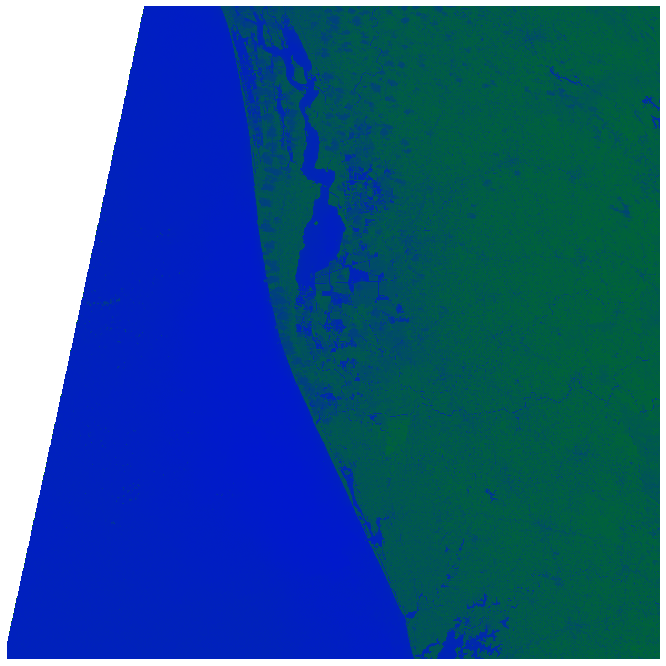

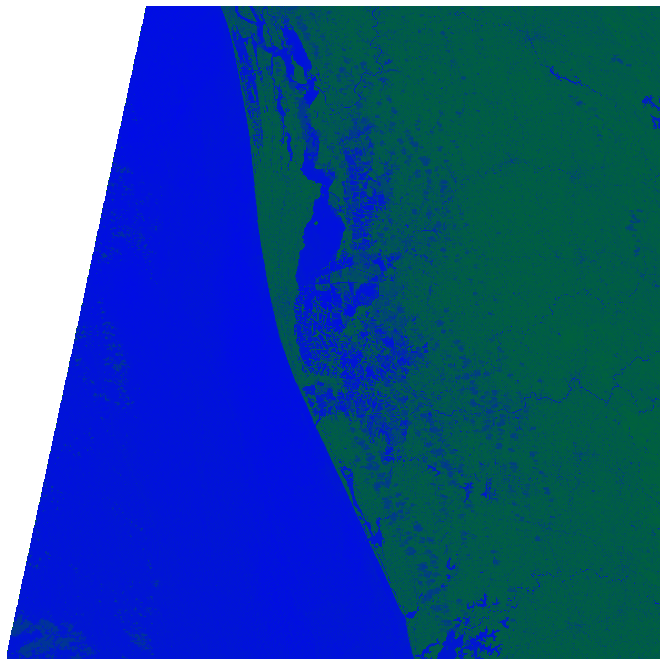

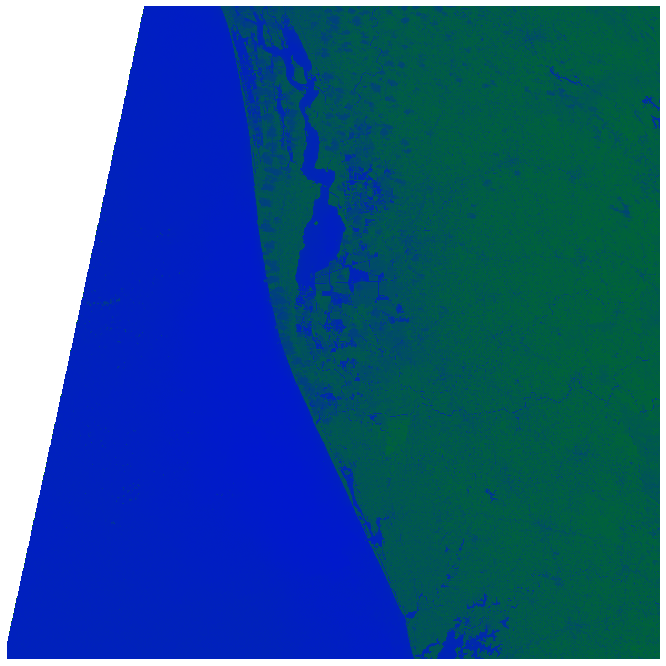

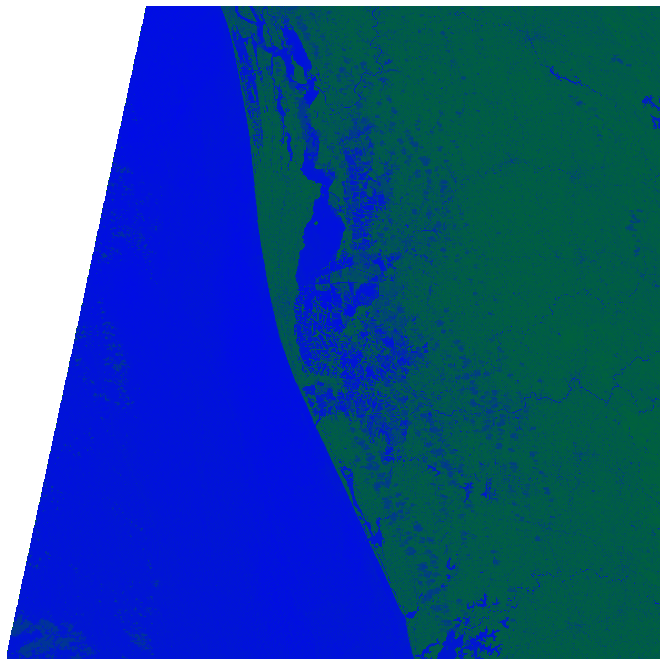

In [14]:
app = Flask(__name__)
api = Api(app)
run_with_ngrok(app)   #starts ngrok when the app is run


class Classify(Resource):
    def get(self, keywords):
      # Change directory into the specified case study
      os.chdir("/gdrive/My Drive/NASA SPACE APP/spaceapps_flood/{}".format(keywords))
      # Call the classify method here and return the output
      pre_bytes_obj = classify()
      before_flood(pre_bytes_obj)


api.add_resource(Classify, '/classify/<string:keywords>')

if __name__ == '__main__':
    app.run()